# Deep Neural Networks

## Objective
- Extend the previous 3-layer NN to a **flexible, multi-layer** design.
- Modularize **Fully Connected (FC) layers**, **activation functions** (tanh/sigmoid/**ReLU**), **initializers** (Simple/**Xavier/He**), and **optimizers** (SGD/**AdaGrad**).
- Train and validate on **MNIST**.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Reproducibility
np.random.seed(42)
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.rcParams['axes.grid'] = True

## 1) Load MNIST


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (60000, 28, 28)  Test shape: (10000, 28, 28)
Dtype: uint8


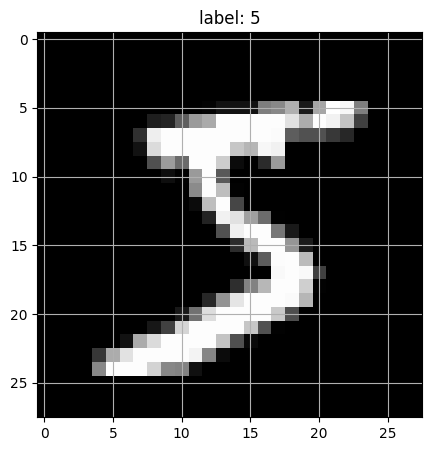

In [2]:
# Load MNIST directly from Keras
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Dtype:", X_train.dtype)


# Peek at one image
idx = 0
plt.figure()
plt.imshow(X_train[idx], cmap='gray')
plt.title(f'label: {y_train[idx]}')
plt.show()

## 2) Preprocessing
- Flatten (N,28,28) → (N,784)
- Normalize to `[0,1]` floats
- One-hot labels (10 classes)
- Split train (48k) / val (12k)


In [3]:
# Flatten & normalize
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0
X_test  = X_test.reshape(-1, 784).astype(np.float32) / 255.0

# One-hot encode
try:
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
except TypeError:
    enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_oh = enc.fit_transform(y_train.reshape(-1,1))
y_test_oh  = enc.transform(y_test.reshape(-1,1))

# Train/val split: 48k / 12k
X_train, X_val, y_train_oh, y_val_oh, y_train, y_val = train_test_split(
    X_train, y_train_oh, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print('X_train:', X_train.shape, ' X_val:', X_val.shape)

X_train: (48000, 784)  X_val: (12000, 784)


## 3) Mini-batch iterator

In [4]:
class GetMiniBatch:
    """Mini-batch iterator"""
    def __init__(self, X, y, batch_size=64, seed=42):
        self.batch_size = int(batch_size)
        rng = np.random.default_rng(seed)
        order = rng.permutation(np.arange(X.shape[0]))
        self._X = X[order]
        self._y = y[order]
        self._stop = int(np.ceil(X.shape[0] / self.batch_size))
        self._i = 0

    def __len__(self): return self._stop

    def __iter__(self):
        self._i = 0
        return self

    def __next__(self):
        if self._i >= self._stop:
            raise StopIteration()
        p0 = self._i * self.batch_size
        p1 = p0 + self.batch_size
        self._i += 1
        return self._X[p0:p1], self._y[p0:p1]

## 4) Math helpers

In [5]:
def softmax_stable(logits):
    shift = logits - logits.max(axis=1, keepdims=True)
    ex = np.exp(shift)
    return ex / ex.sum(axis=1, keepdims=True)

def cross_entropy(y_true_onehot, y_pred_proba, eps=1e-7):
    yp = np.clip(y_pred_proba, eps, 1.0 - eps)
    return -np.mean(np.sum(y_true_onehot * np.log(yp), axis=1))

def accuracy_from_proba(y_true_int, y_pred_proba):
    pred = np.argmax(y_pred_proba, axis=1)
    return float((pred == y_true_int).mean())

## 5) Initializers (Problem 2 & 6)

- **SimpleInitializer(σ)**: Gaussian N(0, σ²).
- **XavierInitializer**: σ = 1/√n_in.
- **HeInitializer**: σ = √(2/n_in).


In [6]:
class SimpleInitializer:
    """Gaussian N(0, sigma^2) initializer."""
    def __init__(self, sigma=0.01):
        self.sigma = float(sigma)
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.standard_normal((n_nodes1, n_nodes2)).astype(np.float32)
    def B(self, n_nodes2):
        return np.zeros(n_nodes2, dtype=np.float32)

class XavierInitializer:
    """Xavier/Glorot: sigma = 1/sqrt(n_in)."""
    def __init__(self): pass
    def W(self, n_nodes1, n_nodes2):
        sigma = 1.0 / np.sqrt(n_nodes1)
        return sigma * np.random.standard_normal((n_nodes1, n_nodes2)).astype(np.float32)
    def B(self, n_nodes2):
        return np.zeros(n_nodes2, dtype=np.float32)

class HeInitializer:
    """He: sigma = sqrt(2/n_in)."""
    def __init__(self): pass
    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2.0 / n_nodes1)
        return sigma * np.random.standard_normal((n_nodes1, n_nodes2)).astype(np.float32)
    def B(self, n_nodes2):
        return np.zeros(n_nodes2, dtype=np.float32)

## 6) Optimizers (Problem 3 & 7)

- **SGD(lr)**: standard gradient step.
- **AdaGrad(lr)**: per-parameter scaling with accumulated squared gradients.


In [7]:
class SGD:
    """Stochastic Gradient Descent"""
    def __init__(self, lr=0.1):
        self.lr = float(lr)
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.db
        return layer

class AdaGrad:
    """AdaGrad optimizer."""
    def __init__(self, lr=0.1, eps=1e-8):
        self.lr = float(lr)
        self.eps = float(eps)
    def update(self, layer):
        if not hasattr(layer, 'hW'):
            layer.hW = np.zeros_like(layer.W, dtype=np.float32)
            layer.hB = np.zeros_like(layer.B, dtype=np.float32)
        layer.hW += layer.dW * layer.dW
        layer.hB += layer.db * layer.db
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.hW) + self.eps)
        layer.B -= self.lr * layer.db / (np.sqrt(layer.hB) + self.eps)
        return layer

## 7) Fully Connected Layer (Problem 1)

In [8]:
class FC:
    """Fully connected layer: n_nodes1 - n_nodes2"""
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_in = int(n_nodes1)
        self.n_out = int(n_nodes2)
        self.optimizer = optimizer
        # Initialize weights/bias using initializer instance
        self.W = initializer.W(self.n_in, self.n_out)
        self.B = initializer.B(self.n_out)
        # caches
        self.X = None
        self.dW = None
        self.db = None
    def forward(self, X):
        self.X = X  # cache
        A = X @ self.W + self.B
        return A
    def backward(self, dA):
        # Gradients
        self.dW = self.X.T @ dA
        self.db = dA.sum(axis=0)
        # Gradient to pass to previous layer
        dZ = dA @ self.W.T
        # Update parameters via optimizer
        self = self.optimizer.update(self)
        return dZ

## 8) Activations (Problem 4 & 5)

- **Tanh**, **Sigmoid**, **ReLU** with `forward`/`backward`.
- **Softmax** with cross-entropy combined gradient in `backward(Z, Y)`.


In [9]:
class Tanh:
    def __init__(self): self.Z = None
    def forward(self, A):
        self.Z = np.tanh(A)
        return self.Z
    def backward(self, dZ_next):
        return dZ_next * (1.0 - self.Z**2)

class Sigmoid:
    def __init__(self): self.Z = None
    def forward(self, A):
        self.Z = 1.0 / (1.0 + np.exp(-(A)))
        return self.Z
    def backward(self, dZ_next):
        return dZ_next * (self.Z * (1.0 - self.Z))

class ReLU:
    def __init__(self): self.Z = None
    def forward(self, A):
        self.Z = np.maximum(0.0, A)
        return self.Z
    def backward(self, dZ_next):
        return dZ_next * (self.Z > 0.0).astype(np.float32)

class Softmax:
    """Softmax (forward) and CE gradient (backward)."""
    def forward(self, A):
        return softmax_stable(A)
    def backward(self, Z, Y):
        # Combined gradient for softmax + cross-entropy: (Z - Y)/N
        N = Y.shape[0]
        return (Z - Y) / float(N)

## 9) ScratchDeepNeuralNetworkClassifier (Problem 8)

pls ignore the spelling errors

- Build arbitrary-depth networks from `FC` and activation instances.
- Supports `Simple/Xavier/He` initializers and `SGD/AdaGrad` optimizers.


In [10]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self,
                 n_features=784,
                 n_output=10,
                 hidden_layers=(256,128),
                 hidden_activation='relu',
                 initializer='he',      # 'simple', 'xavier', 'he'
                 sigma=0.01,            # only used for 'simple'
                 optimizer='sgd',       # 'sgd', 'adagrad'
                 lr=0.1,
                 batch_size=64,
                 epochs=10,
                 seed=42,
                 verbose=True):
        self.n_features = int(n_features)
        self.n_output = int(n_output)
        self.hidden_layers = list(hidden_layers)
        self.hidden_activation = hidden_activation
        self.initializer_name = initializer
        self.sigma = float(sigma)
        self.optimizer_name = optimizer
        self.lr = float(lr)
        self.batch_size = int(batch_size)
        self.epochs = int(epochs)
        self.seed = int(seed)
        self.verbose = verbose

        self.layers = []   # [(FC, act), ..., (FC, Softmax)]
        self.train_loss_ = []
        self.val_loss_ = []
        self.train_acc_ = []
        self.val_acc_ = []

    # Builders
    def _make_initializer(self):
        if self.initializer_name == 'simple':
            return SimpleInitializer(self.sigma)
        elif self.initializer_name == 'xavier':
            return XavierInitializer()
        elif self.initializer_name == 'he':
            return HeInitializer()
        else:
            raise ValueError('initializer must be simple/xavier/he')

    def _make_optimizer(self):
        if self.optimizer_name == 'sgd':
            return SGD(self.lr)
        elif self.optimizer_name == 'adagrad':
            return AdaGrad(self.lr)
        else:
            raise ValueError('optimizer must be sgd/adagrad')

    def _make_activation(self):
        if self.hidden_activation == 'tanh':
            return Tanh()
        elif self.hidden_activation == 'sigmoid':
            return Sigmoid()
        elif self.hidden_activation == 'relu':
            return ReLU()
        else:
            raise ValueError('hidden_activation must be tanh/sigmoid/relu')

    def _build(self):
        rng = np.random.default_rng(self.seed)
        initializer = self._make_initializer()
        optimizer   = self._make_optimizer()

        # Input → first hidden
        in_dim = self.n_features
        self.layers = []
        for h in self.hidden_layers:
            fc = FC(in_dim, h, initializer, optimizer)
            act = self._make_activation()
            self.layers.append((fc, act))
            in_dim = h
        # Hidden → output
        fc_out = FC(in_dim, self.n_output, initializer, optimizer)
        sm = Softmax()
        self.layers.append((fc_out, sm))

    def fit(self, X, y_onehot, X_val=None, y_val_onehot=None, y_int=None, y_val_int=None):
        if not self.layers:
            self._build()
        batcher = GetMiniBatch(X, y_onehot, batch_size=self.batch_size, seed=self.seed)

        for epoch in range(self.epochs):
            # Shuffle batches each epoch (recreate iterator)
            batcher = GetMiniBatch(X, y_onehot, batch_size=self.batch_size, seed=self.seed + epoch)
            for Xb, Yb in batcher:
                # Forward
                A = Xb
                caches_Z = []   # store activations outputs per layer (for hidden acts)
                for (fc, act) in self.layers[:-1]:
                    A = fc.forward(A)
                    Z = act.forward(A)
                    caches_Z.append(Z)
                    A = Z
                # Output layer
                fc_out, sm = self.layers[-1]
                logits = fc_out.forward(A)
                Zout = sm.forward(logits)

                # Backward: softmax+CE first
                dA = sm.backward(Zout, Yb)
                dZ = fc_out.backward(dA)

                # Hidden layers (reverse)
                for i in reversed(range(len(self.layers)-1)):
                    fc, act = self.layers[i]
                    dA_prev = act.backward(dZ)
                    dZ = fc.backward(dA_prev)

            # End of epoch: track losses/acc
            # Forward full train
            yhat_train = self.predict_proba(X)
            tr_loss = cross_entropy(y_onehot, yhat_train)
            self.train_loss_.append(tr_loss)
            if y_int is not None:
                self.train_acc_.append(accuracy_from_proba(y_int, yhat_train))

            if X_val is not None and y_val_onehot is not None:
                yhat_val = self.predict_proba(X_val)
                val_loss = cross_entropy(y_val_onehot, yhat_val)
                self.val_loss_.append(val_loss)
                if y_val_int is not None:
                    self.val_acc_.append(accuracy_from_proba(y_val_int, yhat_val))

            if self.verbose:
                msg = f"Epoch {epoch+1}/{self.epochs} - loss: {tr_loss:.4f}"
                if self.val_loss_:
                    msg += f" - val_loss: {self.val_loss_[-1]:.4f}"
                if self.train_acc_:
                    msg += f" - acc: {self.train_acc_[-1]:.4f}"
                if self.val_acc_:
                    msg += f" - val_acc: {self.val_acc_[-1]:.4f}"
                print(msg)
        return self

    def predict_proba(self, X):
        if not self.layers:
            self._build()
        A = X
        for (fc, act) in self.layers[:-1]:
            A = act.forward(fc.forward(A))
        fc_out, sm = self.layers[-1]
        logits = fc_out.forward(A)
        return sm.forward(logits)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

## 10) Train helpers: plot learning curves

In [11]:
def plot_curves(model, title_prefix='Model'):
    plt.figure()
    plt.plot(model.train_loss_, label='train')
    if len(model.val_loss_) == len(model.train_loss_):
        plt.plot(model.val_loss_, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.title(f'{title_prefix} — Loss')
    plt.legend()
    plt.show()

    if model.train_acc_ and model.val_acc_:
        plt.figure()
        plt.plot(model.train_acc_, label='train')
        plt.plot(model.val_acc_, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'{title_prefix} — Accuracy')
        plt.legend()
        plt.show()

## 11) Experiments (Problem 9): Different depths & activations

We train a few configurations and report validation/test accuracy.


Epoch 1/8 - loss: 0.2671 - val_loss: 0.2792 - acc: 0.9220 - val_acc: 0.9172
Epoch 2/8 - loss: 0.1904 - val_loss: 0.2061 - acc: 0.9450 - val_acc: 0.9398
Epoch 3/8 - loss: 0.1474 - val_loss: 0.1699 - acc: 0.9567 - val_acc: 0.9514
Epoch 4/8 - loss: 0.1167 - val_loss: 0.1440 - acc: 0.9664 - val_acc: 0.9573
Epoch 5/8 - loss: 0.0960 - val_loss: 0.1291 - acc: 0.9728 - val_acc: 0.9609
Epoch 6/8 - loss: 0.0820 - val_loss: 0.1185 - acc: 0.9761 - val_acc: 0.9641
Epoch 7/8 - loss: 0.0739 - val_loss: 0.1125 - acc: 0.9789 - val_acc: 0.9658
Epoch 8/8 - loss: 0.0618 - val_loss: 0.1035 - acc: 0.9828 - val_acc: 0.9692


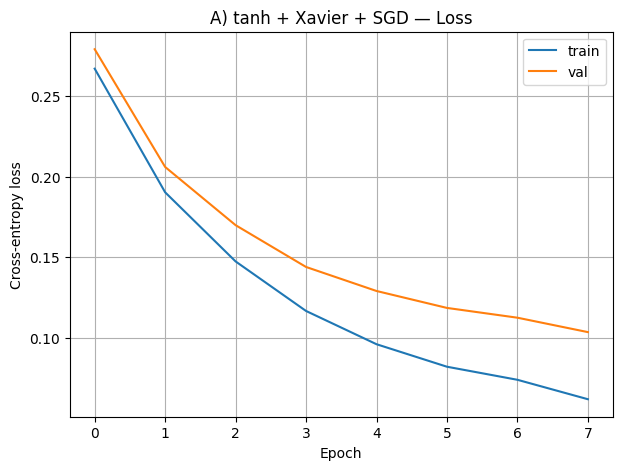

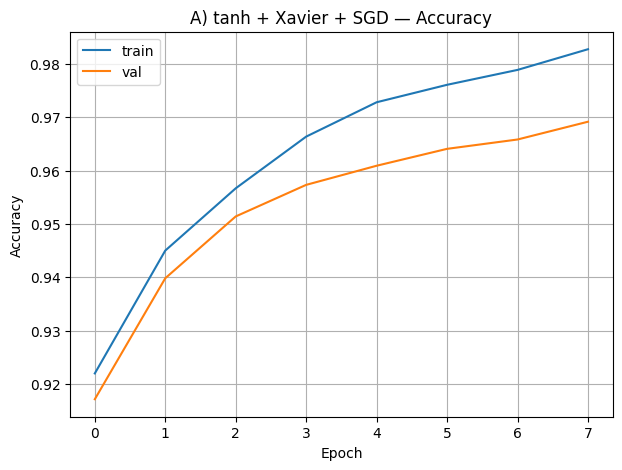

A) Val acc: 0.9692  Test acc: 0.9716
Epoch 1/8 - loss: 0.1803 - val_loss: 0.1965 - acc: 0.9482 - val_acc: 0.9444
Epoch 2/8 - loss: 0.1235 - val_loss: 0.1480 - acc: 0.9640 - val_acc: 0.9564
Epoch 3/8 - loss: 0.0862 - val_loss: 0.1184 - acc: 0.9750 - val_acc: 0.9646
Epoch 4/8 - loss: 0.0720 - val_loss: 0.1108 - acc: 0.9788 - val_acc: 0.9668
Epoch 5/8 - loss: 0.0562 - val_loss: 0.1030 - acc: 0.9842 - val_acc: 0.9691
Epoch 6/8 - loss: 0.0392 - val_loss: 0.0880 - acc: 0.9899 - val_acc: 0.9741
Epoch 7/8 - loss: 0.0342 - val_loss: 0.0899 - acc: 0.9906 - val_acc: 0.9750
Epoch 8/8 - loss: 0.0256 - val_loss: 0.0839 - acc: 0.9941 - val_acc: 0.9761


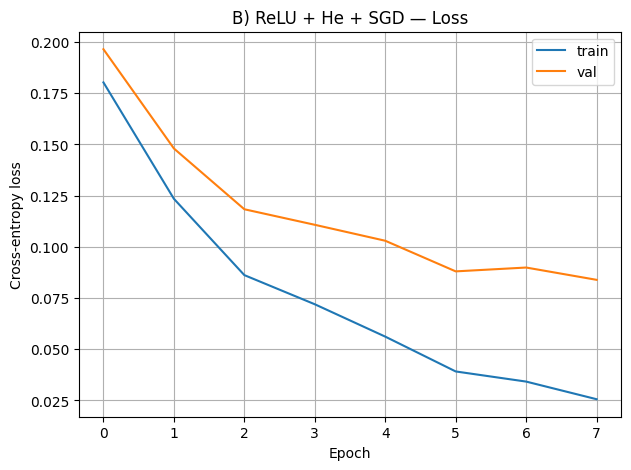

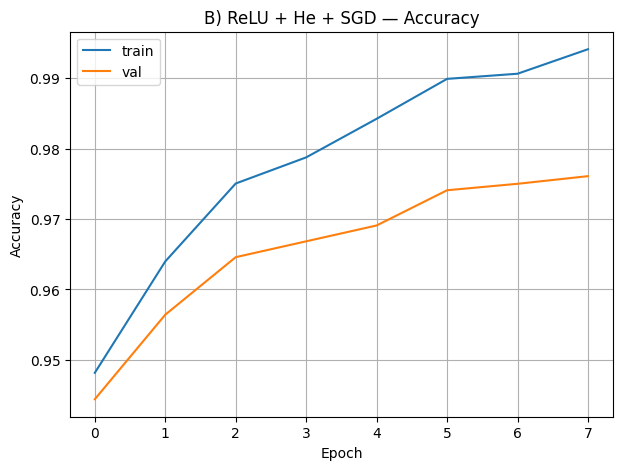

B) Val acc: 0.9761  Test acc: 0.9755
Epoch 1/8 - loss: 0.3557 - val_loss: 0.3685 - acc: 0.8974 - val_acc: 0.8961
Epoch 2/8 - loss: 0.2496 - val_loss: 0.2758 - acc: 0.9251 - val_acc: 0.9200
Epoch 3/8 - loss: 0.2058 - val_loss: 0.2403 - acc: 0.9385 - val_acc: 0.9312
Epoch 4/8 - loss: 0.1873 - val_loss: 0.2325 - acc: 0.9443 - val_acc: 0.9352
Epoch 5/8 - loss: 0.1545 - val_loss: 0.2105 - acc: 0.9526 - val_acc: 0.9410
Epoch 6/8 - loss: 0.1344 - val_loss: 0.1895 - acc: 0.9592 - val_acc: 0.9473
Epoch 7/8 - loss: 0.1191 - val_loss: 0.1823 - acc: 0.9633 - val_acc: 0.9487
Epoch 8/8 - loss: 0.1025 - val_loss: 0.1758 - acc: 0.9684 - val_acc: 0.9520


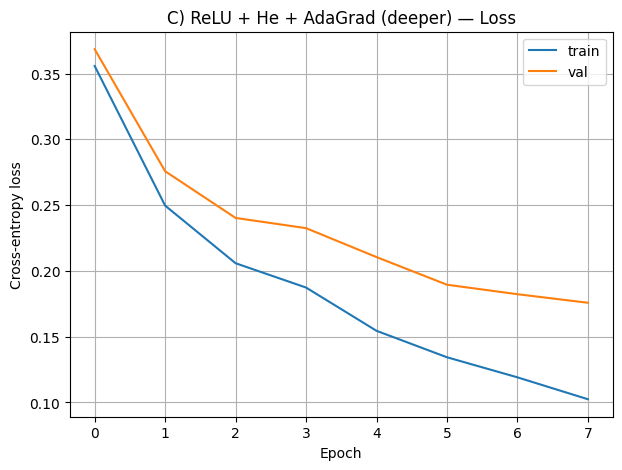

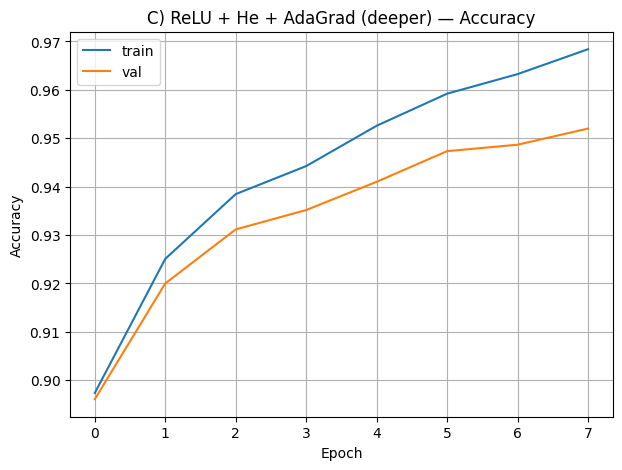

C) Val acc: 0.9520  Test acc: 0.9533

Summary (name, val_acc, test_acc):
('A: tanh+xavier+sgd', 0.9691666666666666, 0.9716)
('B: relu+he+sgd', 0.9760833333333333, 0.9755)
('C: relu+he+adagrad deeper', 0.952, 0.9533)


In [12]:
results = []

# A) tanh + Xavier
model_A = ScratchDeepNeuralNetrowkClassifier(
    hidden_layers=(256,128),
    hidden_activation='tanh',
    initializer='xavier',
    optimizer='sgd',
    lr=0.1,
    batch_size=64,
    epochs=8,
    verbose=True
)
model_A.fit(X_train, y_train_oh, X_val=X_val, y_val_onehot=y_val_oh, y_int=y_train, y_val_int=y_val)
plot_curves(model_A, 'A) tanh + Xavier + SGD')
val_acc_A = accuracy_from_proba(y_val, model_A.predict_proba(X_val))
test_acc_A = accuracy_from_proba(y_test, model_A.predict_proba(X_test))
print('A) Val acc:', f'{val_acc_A:.4f}', ' Test acc:', f'{test_acc_A:.4f}')
results.append(('A: tanh+xavier+sgd', val_acc_A, test_acc_A))

# B) ReLU + He
model_B = ScratchDeepNeuralNetrowkClassifier(
    hidden_layers=(256,128),
    hidden_activation='relu',
    initializer='he',
    optimizer='sgd',
    lr=0.1,
    batch_size=64,
    epochs=8,
    verbose=True
)
model_B.fit(X_train, y_train_oh, X_val=X_val, y_val_onehot=y_val_oh, y_int=y_train, y_val_int=y_val)
plot_curves(model_B, 'B) ReLU + He + SGD')
val_acc_B = accuracy_from_proba(y_val, model_B.predict_proba(X_val))
test_acc_B = accuracy_from_proba(y_test, model_B.predict_proba(X_test))
print('B) Val acc:', f'{val_acc_B:.4f}', ' Test acc:', f'{test_acc_B:.4f}')
results.append(('B: relu+he+sgd', val_acc_B, test_acc_B))

# C) Deeper ReLU + He + AdaGrad
model_C = ScratchDeepNeuralNetrowkClassifier(
    hidden_layers=(512,256,128),
    hidden_activation='relu',
    initializer='he',
    optimizer='adagrad',
    lr=0.2,
    batch_size=128,
    epochs=8,
    verbose=True
)
model_C.fit(X_train, y_train_oh, X_val=X_val, y_val_onehot=y_val_oh, y_int=y_train, y_val_int=y_val)
plot_curves(model_C, 'C) ReLU + He + AdaGrad (deeper)')
val_acc_C = accuracy_from_proba(y_val, model_C.predict_proba(X_val))
test_acc_C = accuracy_from_proba(y_test, model_C.predict_proba(X_test))
print('C) Val acc:', f'{val_acc_C:.4f}', ' Test acc:', f'{test_acc_C:.4f}')
results.append(('C: relu+he+adagrad deeper', val_acc_C, test_acc_C))

print('\nSummary (name, val_acc, test_acc):')
for r in results:
    print(r)

Just like the previous assignment, the validation accuracy improves in each epoch. The ReLU + Stochastic Gradient Descent model performs best with a prediction accuracy of 97.61.

## 12) Misclassifications

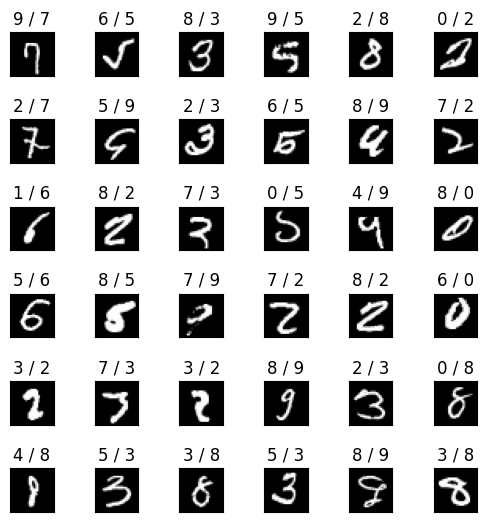

In [13]:
def show_misclassified(model, Xv, yv, n=36):
    proba = model.predict_proba(Xv)
    y_pred = np.argmax(proba, axis=1)
    wrong = np.where(y_pred != yv)[0]
    if wrong.size == 0:
        print('No misclassifications.')
        return
    n = min(n, wrong.size)
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(6,6))
    fig.subplots_adjust(left=0, right=0.8, bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(n):
        idx = wrong[i]
        ax = fig.add_subplot(6, 6, i+1, xticks=[], yticks=[])
        ax.set_title(f'{y_pred[idx]} / {yv[idx]}')
        ax.imshow(Xv[idx].reshape(28,28), cmap='gray')
    plt.show()

# Example on the last model
show_misclassified(model_C, X_val, y_val, n=36)